# Optosynth

... is it _really_ synthetic?! :-)

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, 'sources'))
sys.path.insert(0, sources_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pprint import pprint

from specs import *
from optosynth import Optosynth

device = torch.device("cpu")
dtype = torch.float32

## Paths

In [2]:
optosynth_data_path = '/home/jupyter/mb-ml-data/Optosynth'
output_path = '/home/jupyter/mb-ml-data/Optosynth_output'
output_prefix = 'test_data'

if not os.path.exists(output_path):
    os.mkdir(output_path)

## (Optional) Download pre-processed Allen Brain data

In [3]:
if not os.path.exists(optosynth_data_path):
    os.mkdir(optosynth_data_path)
assert os.path.exists(optosynth_data_path)
data_bucket = 'gs://mb_optosynth_data'

In [ ]:
%%bash -s "$data_bucket" "$optosynth_data_path"
mkdir -p $2
gsutil -m cp -r $1/* $2

## Load summary of available sweeps

In [4]:
# summary of sweeps
ephys_summary_df = pd.read_csv(
    os.path.join(optosynth_data_path, 'processed_electrophysiology_summary.csv'), index_col=0)
ephys_summary_df.head()

,cell_id,sweep_index,stim_amp,n_spikes
0,480116737,0,-110.000000,0
1,480116737,1,-70.000000,0
2,480116737,2,-50.000000,0
3,480116737,3,-30.000002,0
4,480116737,4,10.000000,0


## Optosynth Specs

In [5]:
opto_specs = OptosynthSpecs(
    width=512,
    height=180,
    sampling_rate=500,
    duration_per_segment=2.00,
    scale_factor=2.00,
    n_neurons=50,
    min_neuron_fluorescence_scale_factor=0.1,
    max_neuron_fluorescence_scale_factor=1.0,
    stim_amp_range_list=[
        (25, 50),
        (50, 75),
        (75, 100),
        (100, 125),
        (125, 150),
        (150, 175),
        (175, 200)])

neuron_specs = SyntheticNeuronSpecs(
    dendritic_backprop_velocity=5e4,
    dendritic_backprop_decay_lengthscale=50,
    min_reporter_density=1,
    max_reporter_density=10,
    reporter_density_var_lengthscale=1,
    n_integ_points=5)

bg_specs = BackgroundFluorescenceSpecs(
    dynamic_n_components=20,
    dynamic_x_lengthscale=10,
    dynamic_y_lengthscale=100,
    dynamic_fluorophore_density_scale=0.5,
    dynamic_temporal_frequency=100,
    static_x_lengthscale=5,
    static_y_lengthscale=5,
    static_min_total_fluorophore_density=0.0,
    static_max_total_fluorophore_density=0.1)    

v2f_specs = VoltageToFluorescenceSpecs(
    beta=0.01,
    v1=-100,
    f1=0.4,
    v2=50,
    f2=1.0)

cam_specs = CameraSpecs(
    dc_offset=500,
    gaussian_noise_std=10.,
    psf_lengthscale=1.,
    readout_per_photon=2.2,
    photon_per_fluorophore=50.)

## Generate

In [ ]:
synth = Optosynth(
    opto_specs=opto_specs,
    neuron_specs=neuron_specs,
    bg_specs=bg_specs,
    v2f_specs=v2f_specs,
    cam_specs=cam_specs,
    ephys_summary_df=ephys_summary_df,
    optosynth_data_path=optosynth_data_path,
    device=device,
    dtype=dtype)

## Save

In [ ]:
synth.save(os.path.join(output_path, output_prefix))

## Explore

In [6]:
for _, _, file in os.walk(os.path.join(output_path, output_prefix)):
    pprint(file)

['noisy_movie_tyx.npy',
 'neuron_mean_fluorescence_nt.npy',
 'background_tyx.npy',
 'soma_coords_n2.npy',
 'clean_movie_tyx.npy',
 'clean_fluorescence_tyx.npy',
 'masks_nyx.npy']


In [7]:
masks_nyx = np.load(os.path.join(output_path, output_prefix, 'masks_nyx.npy'))
clean_fluorescence_tyx = np.load(os.path.join(output_path, output_prefix, 'clean_fluorescence_tyx.npy'))
clean_movie_tyx = np.load(os.path.join(output_path, output_prefix, 'clean_movie_tyx.npy'))
noisy_movie_tyx = np.load(os.path.join(output_path, output_prefix, 'noisy_movie_tyx.npy'))

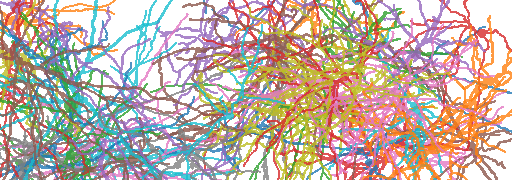

In [8]:
from PIL import Image, ImageOps 

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
combined_masks = Image.new('RGBA', size=(opto_specs.width, opto_specs.height))

for i_neuron in range(opto_specs.n_neurons):
    c_mask = Image.fromarray(masks_nyx[i_neuron, ...])
    c_mask = ImageOps.colorize(
        c_mask.convert('L'),
        black='black',
        white=colors[i_neuron % len(colors)])
    c_mask = c_mask.convert('RGBA')
    c_pixels = c_mask.load()
    for x in range(opto_specs.width):
        for y in range(opto_specs.height):
            if c_pixels[x, y] == (0, 0, 0, 255):
                c_pixels[x, y] = (0, 0, 0, 0)
            else:
                c_pixels[x, y] = c_pixels[x, y][:3] + (200,)
    combined_masks.alpha_composite(c_mask)
combined_masks

In [29]:
idx = 6500

In [34]:
frame_yx = clean_fluorescence_tyx[idx, ...]
normed_frame_yx = 255 * (frame_yx - np.min(frame_yx)) / (np.max(frame_yx) - np.min(frame_yx))
frame_0 = Image.fromarray(normed_frame_yx).convert('RGBA')
frame_0.alpha_composite(combined_masks)

frame_yx = clean_fluorescence_tyx[idx, ...]
normed_frame_yx = 255 * (frame_yx - np.min(frame_yx)) / (np.max(frame_yx) - np.min(frame_yx))
frame_1 = Image.fromarray(normed_frame_yx).convert('RGBA')

frame_yx = clean_movie_tyx[idx, ...]
normed_frame_yx = 255 * (frame_yx - np.min(frame_yx)) / (np.max(frame_yx) - np.min(frame_yx))
frame_2 = Image.fromarray(normed_frame_yx).convert('RGBA')

frame_yx = noisy_movie_tyx[idx, ...].copy()
mean_yx = np.mean(noisy_movie_tyx[:50, ...], axis=0)
frame_yx -= mean_yx
normed_frame_yx = 255 * (frame_yx - np.min(frame_yx)) / (np.max(frame_yx) - np.min(frame_yx))
frame_3 = Image.fromarray(normed_frame_yx).convert('RGBA')

In [40]:
frame_0.save('./frame_0.png')
frame_1.save('./frame_1.png')
frame_2.save('./frame_2.png')
frame_3.save('./frame_3.png')